In [1]:
import torch
import os
import numpy as np
import platform
import sys
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
if 'Windows' in platform.platform():
    sys.path.append("E:\\vscprojects\\pytorch-relative-attributes")
else:
    sys.path.append("..")
from bable.builders import datasets_builder, models_builder
from bable.utils.gradcam_util import GradCam, preprocess_image, get_merged_heatmap_image
from bable.utils.dataloader_utils import PrefetchDataLoader

In [2]:
dataset_type = 'place_pulse_predict'
dataset_params = {
    'min_width': 224,
    'min_height': 224,
    'is_bgr': False
}
dataset = datasets_builder.build_dataset(dataset_type, **dataset_params)
dataset_loader = PrefetchDataLoader(
    dataset, batch_size=1, num_workers=20,
)

In [3]:
ckpt_path = "E:\\vscprojects\pytorch-relative-attributes\logs\logs-place_pulse_safety_32-drn_vgg16-loss_ranknet-RMSprop_0.0001_1e-05-wd1e-05-default\eval\max_accuracy_0.6534.pth"

# method 1
model = torch.load(ckpt_path)

# # method 2
# model_type = 'drn'
# model_params = {
#     'extractor_type': 'vgg16'
# }
# model = models_builder.build_model(model_type, **model_params)
# model.load_state_dict(torch.load(ckpt_path))

model.eval()
model

DRN(
  (ranker): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Max

In [4]:
with torch.no_grad():
    image_list = []
    scores = []
    for d in tqdm(dataset_loader):
        r = model.ranker(d[1].to("cuda:0"))
        image_list.append(d[0][0])
        scores.append(r.cpu().numpy()[0][0])

100%|██████████| 110652/110652 [26:14<00:00, 70.29it/s]


In [5]:
scores = np.array(scores)
s = (scores - np.min(scores))/(np.max(scores) - np.min(scores))

(array([8.0000e+00, 9.0000e+01, 1.3020e+03, 8.6700e+03, 2.3532e+04,
        2.9684e+04, 2.6474e+04, 1.6776e+04, 3.9730e+03, 1.4300e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

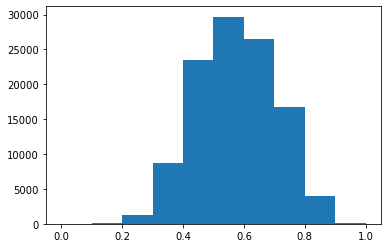

In [6]:
plt.hist(s, bins=10)

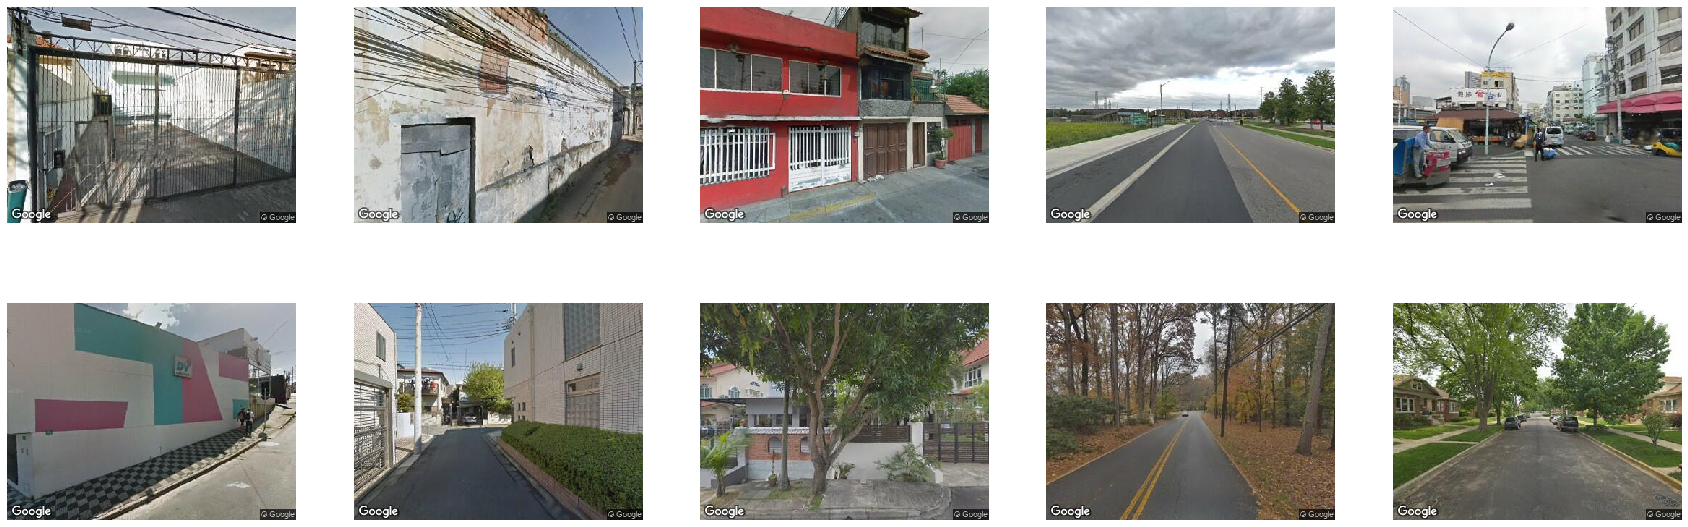

In [7]:
idx = []
for i in np.arange(0, 1, 0.1):
    min_score = i
    max_score = i + 0.1
    ids = np.where((s >= min_score) & (s < max_score))[0]
    np.random.shuffle(ids)
    idx.append(ids[0])
fig = plt.figure(figsize=(30, 10))
for i, id in enumerate(idx):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    ax.imshow(cv2.imread(image_list[id])[:,:,::-1])
plt.show()

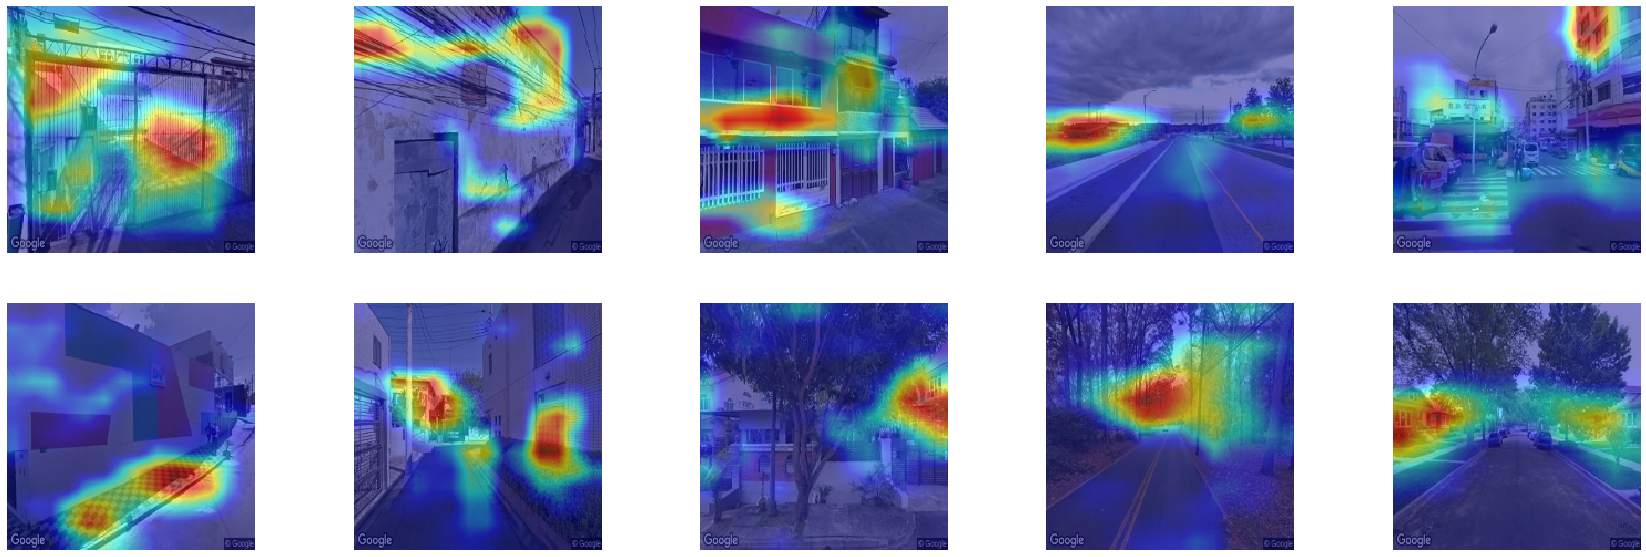

In [10]:
fig = plt.figure(figsize=(30, 10))
grad_cam = GradCam(model.ranker, ["28"], True)
for i, id in enumerate(idx):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    img = cv2.imread(image_list[id])
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)
    mask = grad_cam(input, None)
    ax.imshow(get_merged_heatmap_image(img, mask))
plt.show()